# **Welcome to Walmart Project**

In [1]:
# import the required libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")
plt.style.use("dark_background")


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
# import the required dataset
df_walmart = pd.read_csv(r'D:\Intellipaat\Datasets\Walmart.csv')
df_walmart

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


### 1. You are provided with the weekly sales data for their various outlets.<br/> Use statistical analysis, EDA, outlier analysis, and handle the missing values to <br/>come up with various insights that can give them a clear perspective on the following:

## Exploratory Data Analysis

In [3]:
# check for the null values in dataset
df_walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [4]:
# convert the date column data type to datetime
df_walmart['Date'] = pd.to_datetime(df_walmart['Date'], dayfirst=True)
df_walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [5]:
# convert the column names to lowercase
df_walmart.columns = df_walmart.columns.str.lower()

In [6]:
# check for the duplicates in dataset
df_walmart[df_walmart.duplicated()]

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment


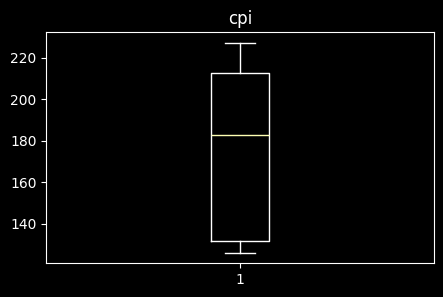

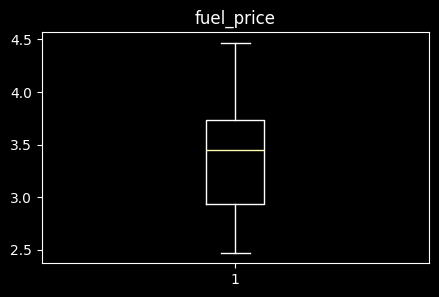

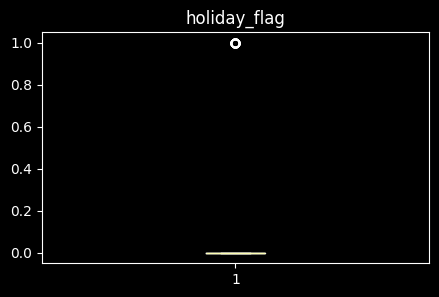

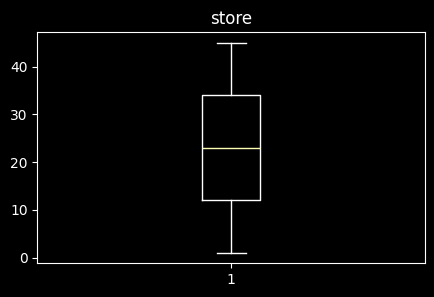

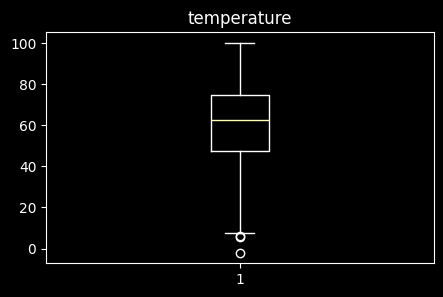

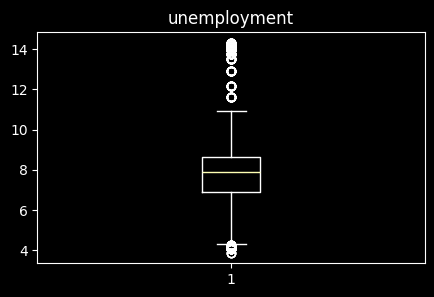

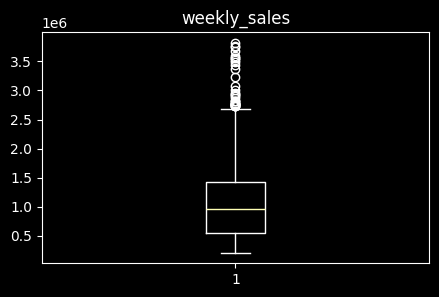

In [7]:
# check for the outliers in dataset
for col in df_walmart.columns.difference(['date']):
    plt.figure(figsize=(5, 3))
    plt.boxplot(df_walmart[col])
    plt.title(col)
    plt.show()

**Inference** :- 
- As we see, 'cpi', 'fuel_price', and 'store' columns are not having any outliers. <br/>

- 'hoiday_flag' is categorical column having 0 values in majority so it is showing 1 as outlier, but it's actually not an outlier/ <br/>

- same in 'unemployment' as 'holiday_flag', maximum no. of area having 4 to 11 unemployed records, so it's showing others as outliers, <br/>
  if we remove those other records then data can become too simple to understand so let it be. <br/>

- 'temperature' column having couple of outliers which isn't a problem cause they are negligible <br/>

- 'Weekly sales' column is having the actual outliers which can be removed (if don't cause more data loss), <br/> 
  else can be handled by replacing with mean or median

## Exploratory Data Analysis

In [8]:
# summary of data
df_walmart.describe()

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


In [9]:
df_walmart['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

##### a. If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?

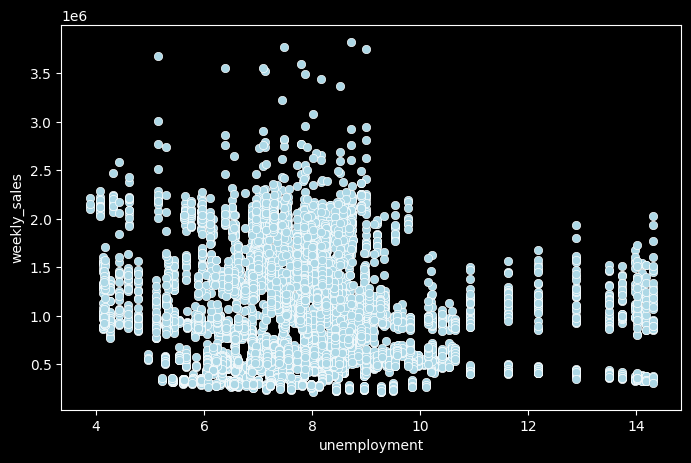

In [10]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_walmart, x='unemployment', y='weekly_sales', color='lightblue')
plt.show()

In [11]:
temp = df_walmart[df_walmart['unemployment'] >= 10]
temp

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
1573,12,2010-02-05,1100046.37,0,49.47,2.962,126.442065,13.975
1574,12,2010-02-12,1117863.33,1,47.87,2.946,126.496258,13.975
1575,12,2010-02-19,1095421.65,0,54.83,2.915,126.526286,13.975
1576,12,2010-02-26,1048617.17,0,50.23,2.825,126.552286,13.975
1577,12,2010-03-05,1077018.27,0,53.77,2.987,126.578286,13.975
...,...,...,...,...,...,...,...,...
6101,43,2011-12-02,585028.26,0,47.49,3.172,210.312607,10.148
6102,43,2011-12-09,617898.07,0,34.23,3.158,210.536357,10.148
6103,43,2011-12-16,665007.08,0,43.78,3.159,210.736539,10.148
6104,43,2011-12-23,676290.46,0,42.63,3.112,210.905297,10.148


In [12]:
temp['store'].unique()

array([12, 28, 29, 33, 34, 38, 43], dtype=int64)

**Insights** :-
- In scatterplot, we see where the 'unemployment' rate goes above 10, in that regions 'weekly sales' hardly goes upto 2 million

- This shows that in some regions 'weekly sales' are affected by 'unemployment' rate
- The stores suffering the most are 12, 28, 29, 33, 34, 38, 43
- Also these stores consist 629 records out of all data

##### b. If the weekly sales show a seasonal trend, when and what could be the reason ?


<Axes: >

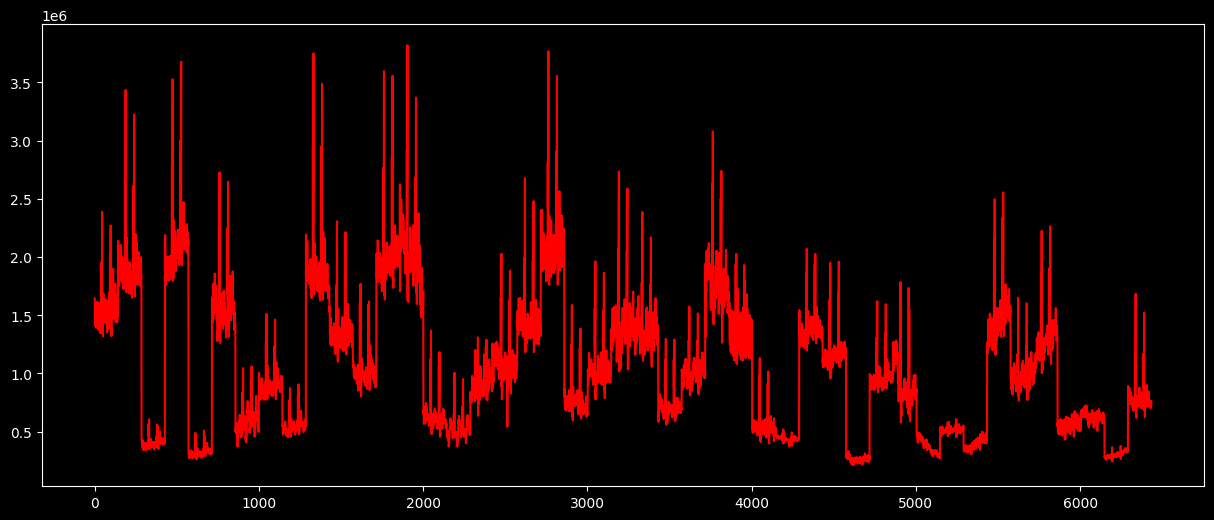

In [13]:
plt.figure(figsize=(15, 6))
df_walmart['weekly_sales'].plot(kind='line', color='red')

##### c. Does temperature affect the weekly sales in any manner?

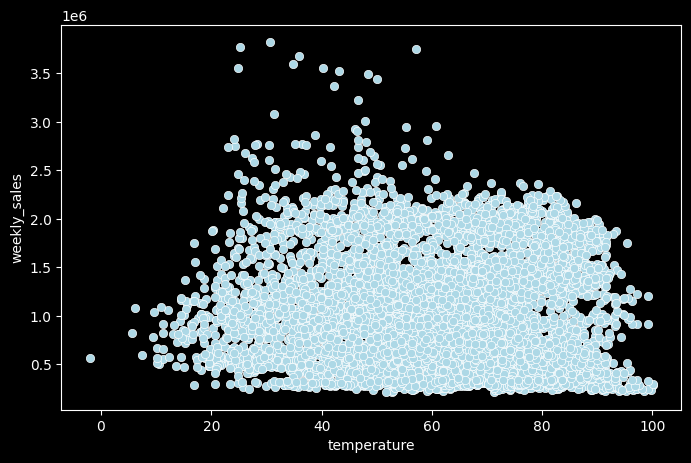

In [14]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_walmart, x='temperature', y='weekly_sales', color='lightblue')
plt.show()

**Insights** :- 
- No, 'temperature' does not affect 'weekly sales' by any manner.

##### d. How is the Consumer Price index affecting the weekly sales of various stores ?

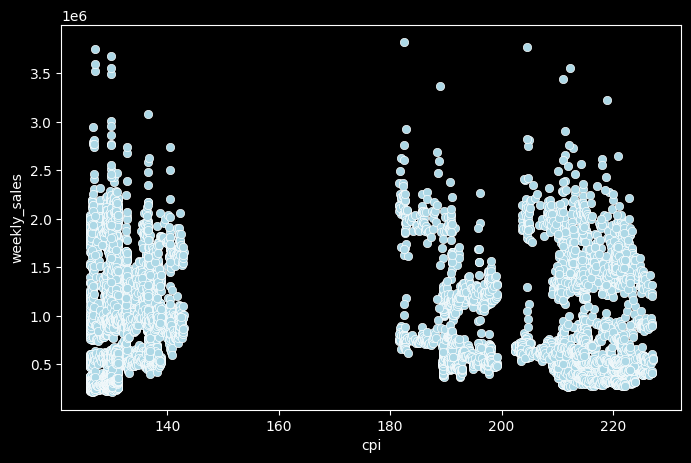

In [15]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_walmart, x='cpi', y='weekly_sales', color='lightblue')
plt.show()

In [16]:
less_142 = df_walmart[df_walmart['cpi'] < 145]
less_142

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
429,4,2010-02-05,2135143.87,0,43.76,2.598,126.442065,8.623
430,4,2010-02-12,2188307.39,1,28.84,2.573,126.496258,8.623
431,4,2010-02-19,2049860.26,0,36.45,2.540,126.526286,8.623
432,4,2010-02-26,1925728.84,0,41.36,2.590,126.552286,8.623
433,4,2010-03-05,1971057.44,0,43.49,2.654,126.578286,8.623
...,...,...,...,...,...,...,...,...
6287,44,2012-09-28,355307.94,0,64.80,3.821,131.043000,5.407
6288,44,2012-10-05,337390.44,0,61.79,3.815,131.075667,5.217
6289,44,2012-10-12,337796.13,0,55.10,3.797,131.108333,5.217
6290,44,2012-10-19,323766.77,0,52.06,3.781,131.149968,5.217


In [17]:
less_142['store'].unique()

array([ 4, 10, 12, 13, 15, 17, 18, 19, 22, 23, 24, 26, 27, 28, 29, 33, 34,
       35, 38, 40, 42, 44], dtype=int64)

In [18]:
more_180 = df_walmart[df_walmart['cpi'] > 180]
more_180

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


In [19]:
more_180['store'].unique()

array([ 1,  2,  3,  5,  6,  7,  8,  9, 11, 14, 16, 20, 21, 25, 30, 31, 32,
       36, 37, 39, 41, 43, 45], dtype=int64)

**Insights** :- 
- Here, we see there are more than 3k stores which are performing good when 'cpi' is less than 145. <br/>
  But when it goes beyond it, these stores won't do well.

- There are more than 3k stores too whose weekly sales is pretty well when 'cpi' is above 180. <br/>
  But when it comes under 180, they also won't do well.

- Also note that there's not even one store who sales are good while 'cpi' is between 145 & 180.

- So this is how consumer price index is affecting the weekly sales of various stores.

##### e. Top performing stores according to the historical data.

In [20]:
store = df_walmart.groupby(by='store')['weekly_sales'].sum().sort_values(ascending=False).reset_index()

In [21]:
store.head(5)

,store,weekly_sales
0,20,3.013978e+08
1,4,2.995440e+08
2,14,2.889999e+08
3,13,2.865177e+08
4,2,2.753824e+08


<Axes: >

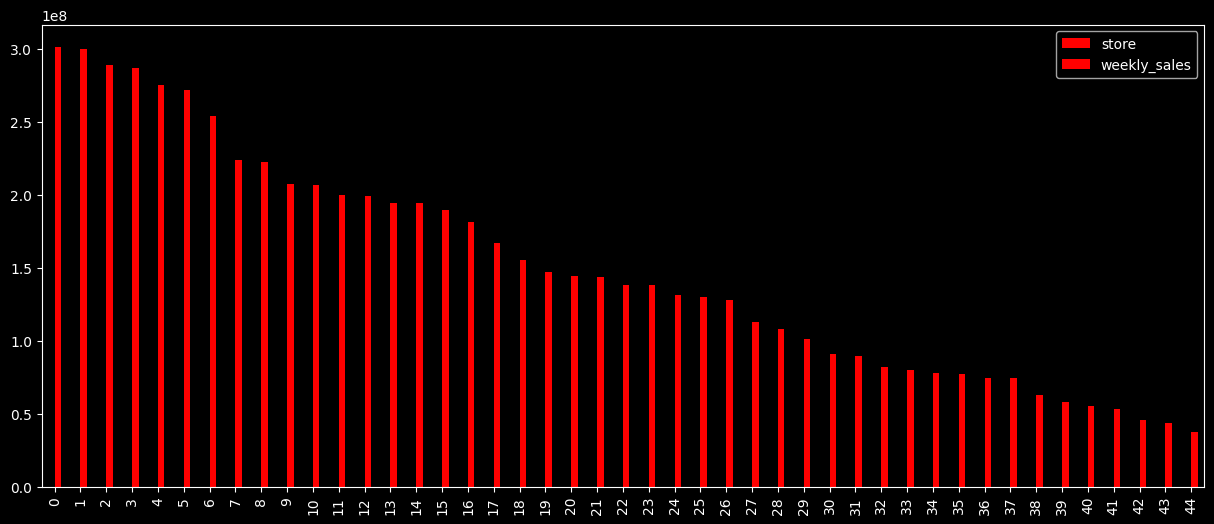

In [22]:
store.plot(kind='bar', figsize=(15, 6), color='red')

**Insights** :- 
- Here, store 20, 4, 14, 13, 2 are the top performing stores according to the historical data

#### f. The worst performing store, and how significant is the difference between the highest and lowest performing stores.

In [23]:
store.tail(5)

,store,weekly_sales
40,38,55159626.42
41,36,53412214.97
42,5,45475688.90
43,44,43293087.84
44,33,37160221.96


**Insights** :- 
- The worst performing stores are 33, 44, 5, 36, 38.

- The difference between the highest & lowest performing stores is approx 26.3 crores.

### 2. Use predictive modeling techniques to forecast the sales for each store for the next 12 weeks.

In [24]:
# Create a copy of data for manipulation & testing
df = df_walmart.copy(deep=True)
df['date'] = df_walmart['date'].dt.day
df['month'] = df_walmart['date'].dt.month
df['year'] = df_walmart['date'].dt.year
df['week'] = df_walmart['date'].dt.isocalendar().week
df

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,month,year,week
0,1,5,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010,5
1,1,12,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010,6
2,1,19,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010,7
3,1,26,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010,8
4,1,5,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010,9
...,...,...,...,...,...,...,...,...,...,...,...
6430,45,28,713173.95,0,64.88,3.997,192.013558,8.684,9,2012,39
6431,45,5,733455.07,0,64.89,3.985,192.170412,8.667,10,2012,40
6432,45,12,734464.36,0,54.47,4.000,192.327265,8.667,10,2012,41
6433,45,19,718125.53,0,56.47,3.969,192.330854,8.667,10,2012,42


### Create plots for some useful insights

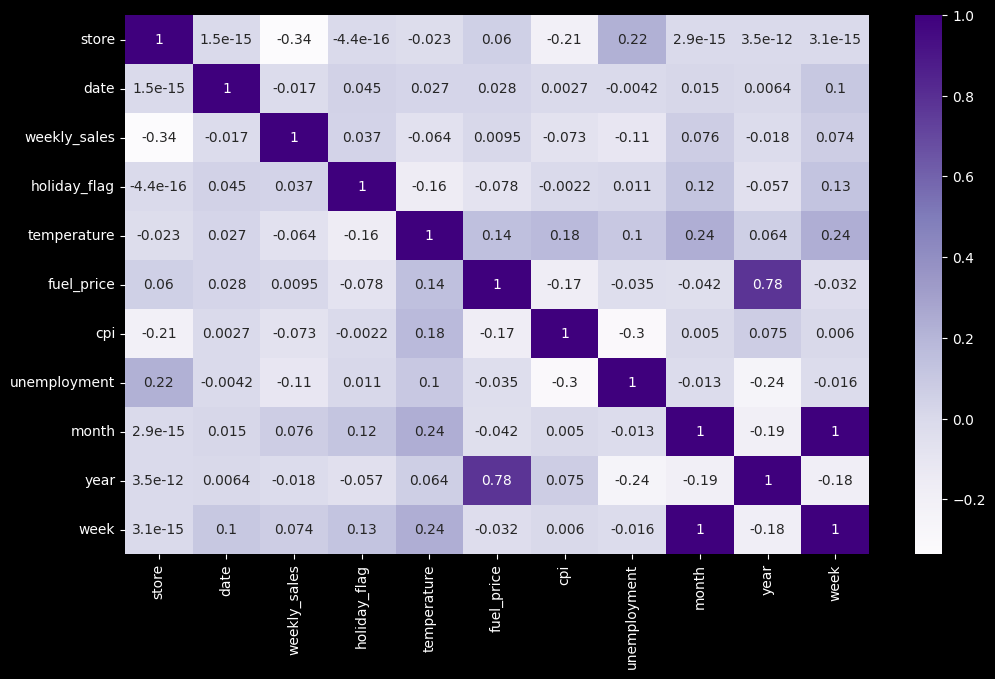

In [25]:
# heatmap for correlation between columns
plt.figure(figsize=(12, 7))
sns.heatmap(data=df.corr(), annot=True, cmap='Purples')
plt.show()

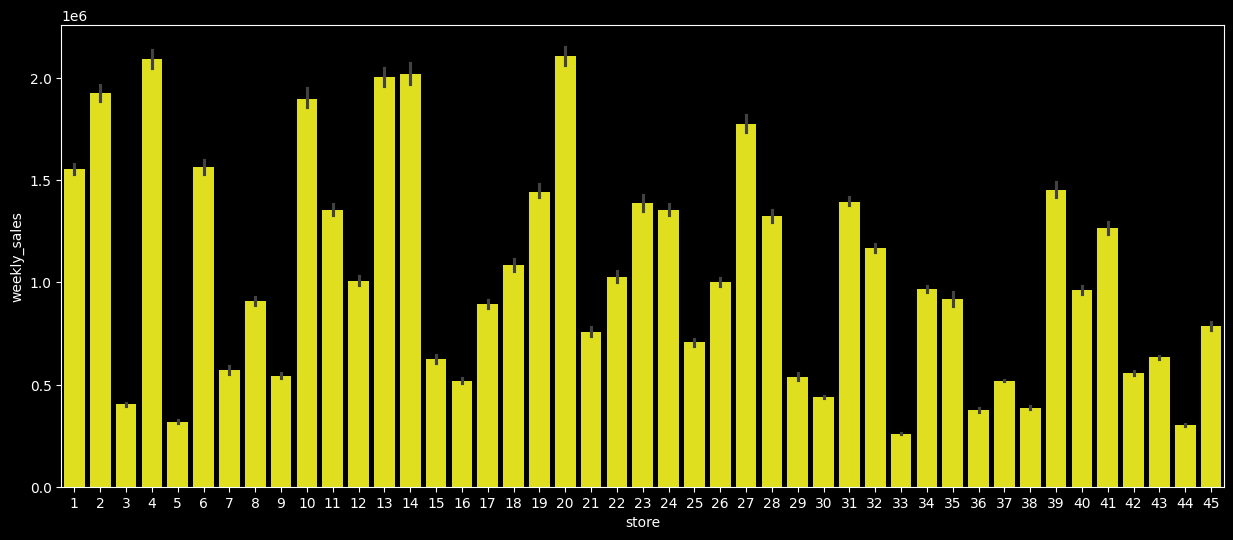

In [26]:
# weekly sales of each store
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='store', y='weekly_sales', color='yellow')
plt.show()

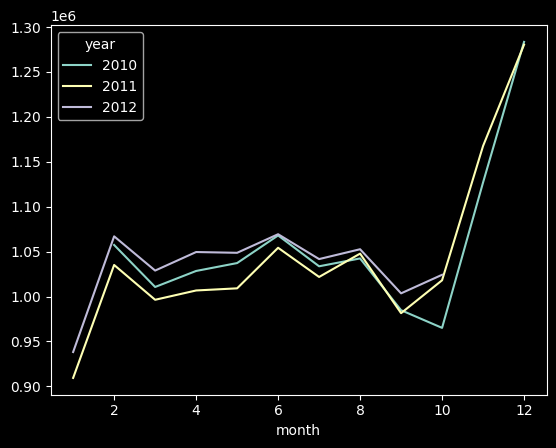

In [27]:
# weekly sales line plot with respect to each month & year
pivot = pd.pivot_table(data=df, values='weekly_sales', columns='year', index='month')
pivot.plot()
plt.show()

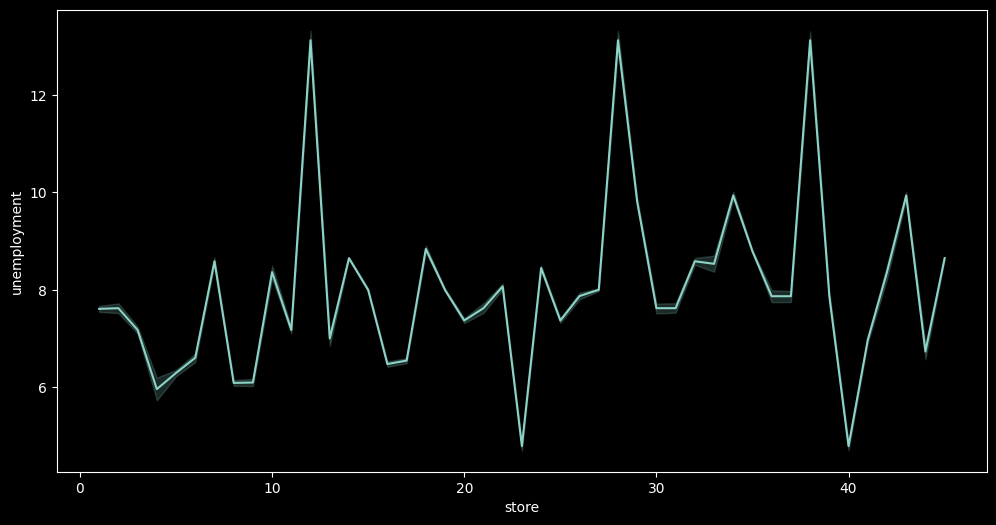

In [28]:
# unemployment within each store
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='store', y='unemployment')
plt.show()

In [29]:
# seperate features & target column
features = df.drop(columns = ['weekly_sales'])
target = df['weekly_sales']

In [30]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(features, target)

RandomForestRegressor()

In [31]:
features

,store,date,holiday_flag,temperature,fuel_price,cpi,unemployment,month,year,week
0,1,5,0,42.31,2.572,211.096358,8.106,2,2010,5
1,1,12,1,38.51,2.548,211.242170,8.106,2,2010,6
2,1,19,0,39.93,2.514,211.289143,8.106,2,2010,7
3,1,26,0,46.63,2.561,211.319643,8.106,2,2010,8
4,1,5,0,46.50,2.625,211.350143,8.106,3,2010,9
...,...,...,...,...,...,...,...,...,...,...
6430,45,28,0,64.88,3.997,192.013558,8.684,9,2012,39
6431,45,5,0,64.89,3.985,192.170412,8.667,10,2012,40
6432,45,12,0,54.47,4.000,192.327265,8.667,10,2012,41
6433,45,19,0,56.47,3.969,192.330854,8.667,10,2012,42


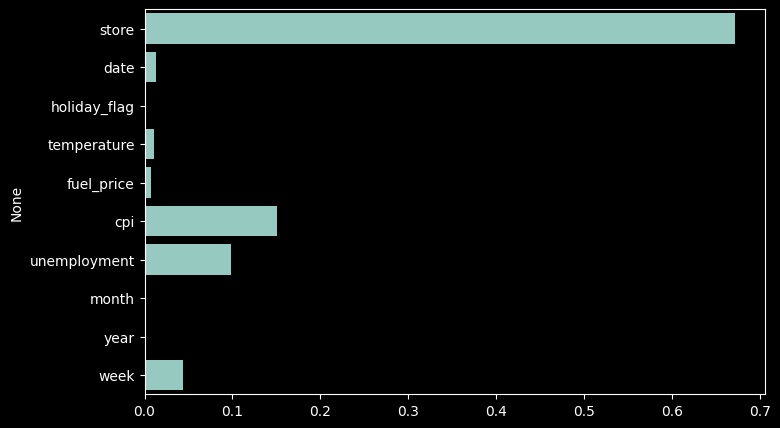

In [32]:
# Display the importance of each feature with target variable
plt.figure(figsize=(8, 5))
sns.barplot(x=rf.feature_importances_, y=features.columns)
plt.show()

In [33]:
# remove columns having less importance
final_features = features.drop(columns=['holiday_flag', 'year', 'temperature', 'fuel_price'])
final_features

,store,date,cpi,unemployment,month,week
0,1,5,211.096358,8.106,2,5
1,1,12,211.242170,8.106,2,6
2,1,19,211.289143,8.106,2,7
3,1,26,211.319643,8.106,2,8
4,1,5,211.350143,8.106,3,9
...,...,...,...,...,...,...
6430,45,28,192.013558,8.684,9,39
6431,45,5,192.170412,8.667,10,40
6432,45,12,192.327265,8.667,10,41
6433,45,19,192.330854,8.667,10,42


In [34]:
# Split the data into training & testing
x_train, x_test, y_train, y_test = train_test_split(final_features, target, test_size=0.2, random_state=21)

In [35]:
# decision tree
model_dt = DecisionTreeRegressor(max_depth=3, random_state=21)
model_dt.fit(x_train, y_train)
y_pred_dt = model_dt.predict(x_test)

In [36]:
print(f'R2 Score :- {r2_score(y_test, y_pred_dt)}')
print(f'MSE Score :- {mean_squared_error(y_test, y_pred_dt)}')
print(f'RMSE Score :- {root_mean_squared_error(y_test, y_pred_dt)}')

R2 Score :- 0.4522194323505
MSE Score :- 182532975464.34863
RMSE Score :- 427238.7803843989


In [37]:
# random forest
model_rf = RandomForestRegressor(max_depth=35, random_state=21, min_samples_split=10)
model_rf.fit(x_train,y_train)
y_pred_rf = model_rf.predict(x_test)

In [38]:
print(f'R2 Score :- {r2_score(y_test, y_pred_rf)}')
print(f'MSE Score :- {mean_squared_error(y_test, y_pred_rf)}')
print(f'RMSE Score :- {root_mean_squared_error(y_test, y_pred_rf)}')

R2 Score :- 0.9663990355224327
MSE Score :- 11196607522.752903
RMSE Score :- 105814.02328024818


In [39]:
# xgboost
model_xg = XGBRegressor()
model_xg.fit(x_train, y_train)
y_pred_xg = model_xg.predict(x_test)

In [40]:
print(f'R2 Score :- {r2_score(y_test, y_pred_xg)}')
print(f'MSE Score :- {mean_squared_error(y_test, y_pred_xg)}')
print(f'RMSE Score :- {root_mean_squared_error(y_test, y_pred_xg)}')

R2 Score :- 0.9817436156372891
MSE Score :- 6083443546.100148
RMSE Score :- 77996.43290625635


**Insights :-**
- XGBoost is performing well as compared to the other model 

### Forecasting of next 12 weeks for 5 stores

In [41]:
# extract the data of 5 stores and perform required manipulation

store_4 = df_walmart[df_walmart['store'] == 4]
store_4 = store_4[['date', 'weekly_sales']]

store_17 = df_walmart[df_walmart['store'] == 17]
store_17 = store_17[['date', 'weekly_sales']]

store_24 = df_walmart[df_walmart['store'] == 24]
store_24 = store_24[['date', 'weekly_sales']]

store_33 = df_walmart[df_walmart['store'] == 33]
store_33 = store_33[['date', 'weekly_sales']]

store_41 = df_walmart[df_walmart['store'] == 41]
store_41 = store_41[['date', 'weekly_sales']]

In [42]:
# Set the 'date column as an index
store_4.set_index('date', drop=True, inplace=True)
store_4

store_17.set_index('date', drop=True, inplace=True)
store_17

store_24.set_index('date', drop=True, inplace=True)
store_24

store_33.set_index('date', drop=True, inplace=True)
store_33

store_41.set_index('date', drop=True, inplace=True)
store_41

,weekly_sales
date,
2010-02-05,1086533.18
2010-02-12,1075656.34
2010-02-19,1052034.74
2010-02-26,991941.73
2010-03-05,1063557.49
...,...
2012-09-28,1307928.01
2012-10-05,1400160.95
2012-10-12,1409544.97


In [43]:
# Group the data on weekly basis
store_4 = store_4.groupby(pd.Grouper(freq = '1W')).sum()
store_4

store_17 = store_17.groupby(pd.Grouper(freq = '1W')).sum()
store_17

store_24 = store_24.groupby(pd.Grouper(freq = '1W')).sum()
store_24

store_33 = store_33.groupby(pd.Grouper(freq = '1W')).sum()
store_33

store_41 = store_41.groupby(pd.Grouper(freq = '1W')).sum()
store_41

,weekly_sales
date,
2010-02-07,1086533.18
2010-02-14,1075656.34
2010-02-21,1052034.74
2010-02-28,991941.73
2010-03-07,1063557.49
...,...
2012-09-30,1307928.01
2012-10-07,1400160.95
2012-10-14,1409544.97


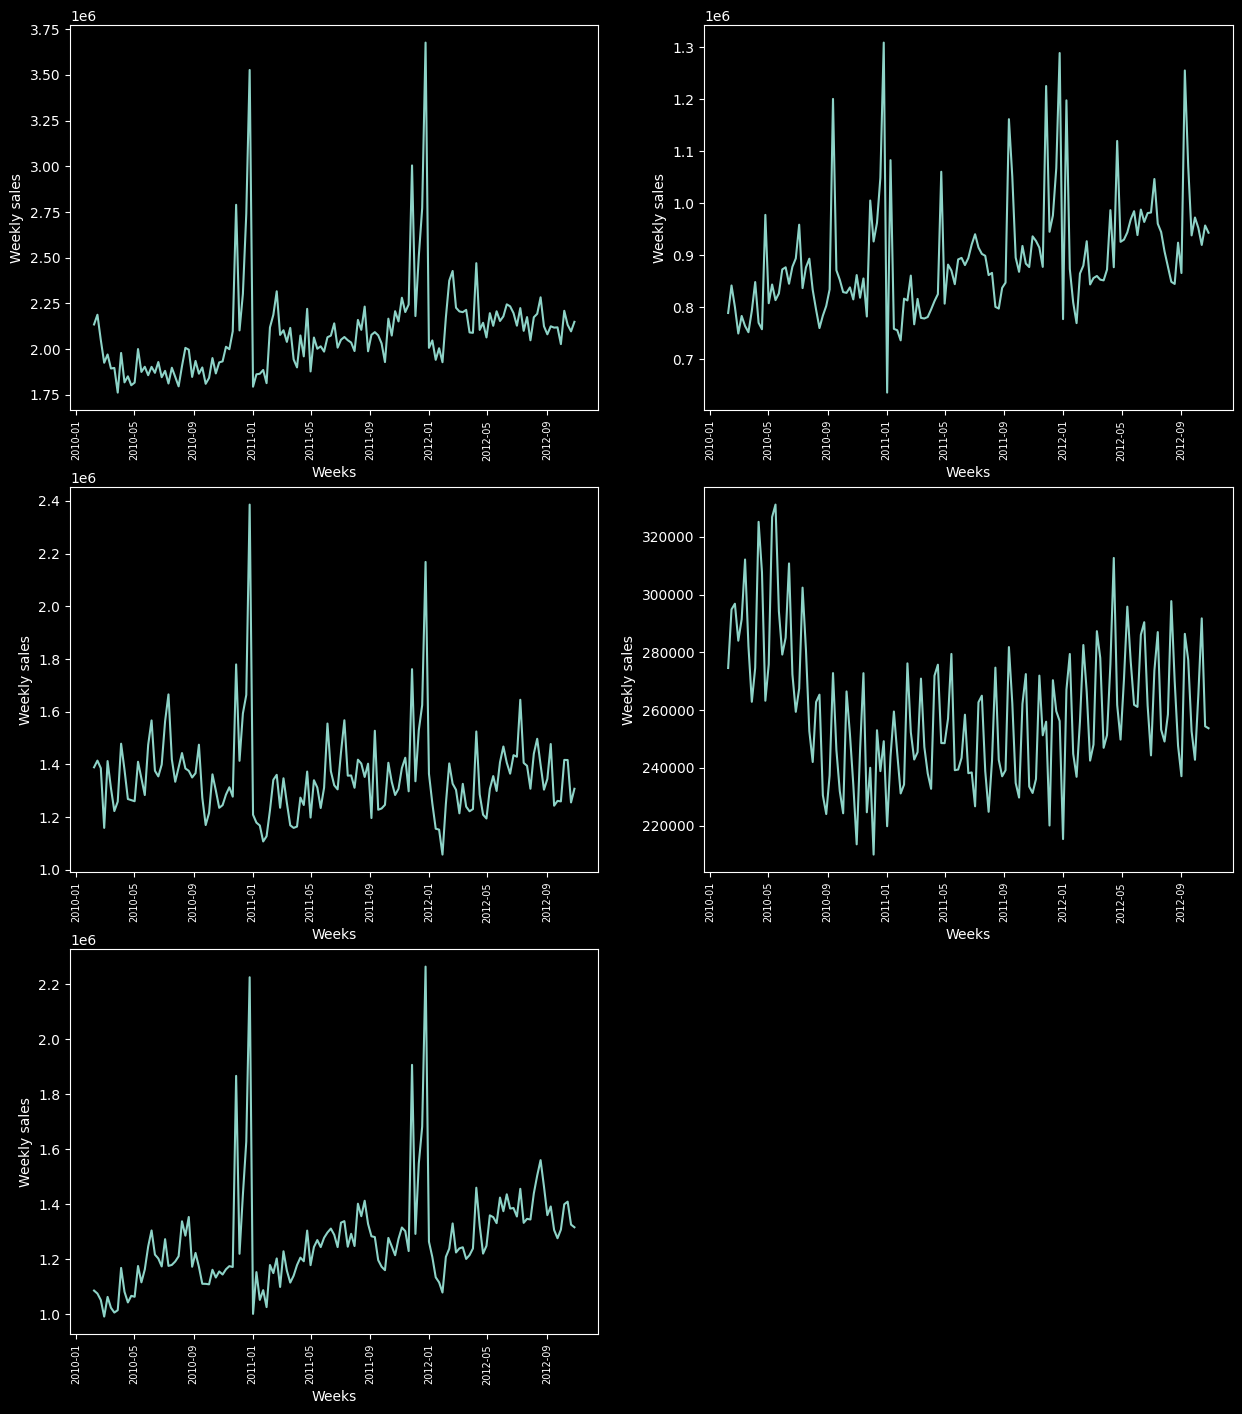

In [44]:
# plot the data of all 5 stores
plt.figure(figsize=(15, 17))

plt.subplot(3, 2, 1)
plt.xticks(rotation=90, fontsize=7)
plt.xlabel('Weeks')
plt.ylabel('Weekly sales')
plt.plot(store_4.index, store_4.weekly_sales)

plt.subplot(3, 2, 2)
plt.xticks(rotation=90, fontsize=7)
plt.xlabel('Weeks')
plt.ylabel('Weekly sales')
plt.plot(store_17.index, store_17.weekly_sales)

plt.subplot(3, 2, 3)
plt.xticks(rotation=90, fontsize=7)
plt.xlabel('Weeks')
plt.ylabel('Weekly sales')
plt.plot(store_24.index, store_24.weekly_sales)

plt.subplot(3, 2, 4)
plt.xticks(rotation=90, fontsize=7)
plt.xlabel('Weeks')
plt.ylabel('Weekly sales')
plt.plot(store_33.index, store_33.weekly_sales)

plt.subplot(3, 2, 5)
plt.xticks(rotation=90, fontsize=7)
plt.xlabel('Weeks')
plt.ylabel('Weekly sales')
plt.plot(store_41.index, store_41.weekly_sales)

plt.show()

In [45]:
# Check for the stationarity in datasets
result = adfuller(store_4['weekly_sales'])
print(f'Store 4 :- {result[1]}')

result = adfuller(store_17['weekly_sales'])
print(f'Store 17 :- {result[1]}')

result = adfuller(store_24['weekly_sales'])
print(f'Store 24 :- {result[1]}')

result = adfuller(store_33['weekly_sales'])
print(f'Store 33 :- {result[1]}')

result = adfuller(store_41['weekly_sales'])
print(f'Store 41 :- {result[1]}')

Store 4 :- 0.04779866223669811
Store 17 :- 5.679177242073061e-06
Store 24 :- 8.281608598042004e-06
Store 33 :- 0.0008379552269735436
Store 41 :- 0.00020648035251554043


**Insight** :- Here, we see that the data of all stores are stationary.

In [46]:
# classify the data into training & testing
train_4 = store_4.iloc[ : 111]
test_4 = store_4.iloc[111 : ]

train_17 = store_17.iloc[ : 111]
test_17 = store_17.iloc[111 : ]

train_24 = store_24.iloc[ : 111]
test_24 = store_24.iloc[111 : ]

train_33 = store_33.iloc[ : 111]
test_33 = store_33.iloc[111 : ]

train_41 = store_41.iloc[ : 111]
test_41 = store_41.iloc[111 : ]

#### 1. Forcasting of store 4

In [47]:
# find the best parameters for store 4
order = auto_arima(store_4, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3941.121, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3974.839, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3961.185, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3951.001, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3972.843, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3942.458, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3943.328, Time=1.01 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3933.917, Time=0.46 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3934.872, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3934.829, Time=0.62 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3935.308, Time=0.61 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3935.805, Time=0.41 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3936.191, Time=1.52 sec
 ARIMA(2,1,3)(0,0,0)[0]             : 

In [48]:
# create & train the model
sarima_4 = SARIMAX(train_4,order=(2, 1, 3),seasonal_order=(2, 1, 3, 52))
sarima_4 = sarima_4.fit()

c:\Users\vinit\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


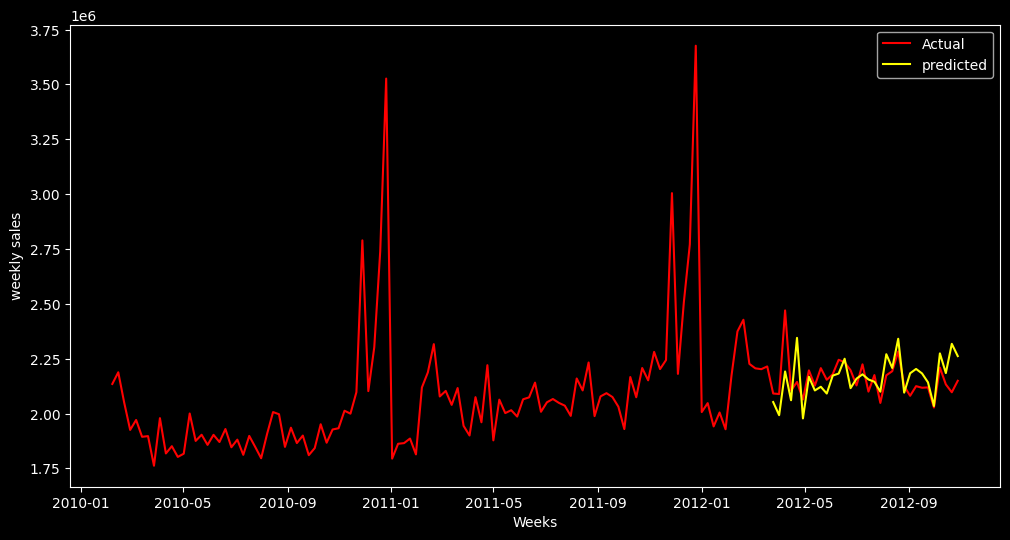

In [49]:
# Predict the data using model
sarima_pred = sarima_4.predict(start = len(train_4), end=len(train_4)+len(test_4)-1, dynamic=True)

# Visualize the predicted data with actual data
plt.figure(figsize=(12, 6))
plt.plot(store_4, color = 'red', label = 'Actual')
plt.plot(sarima_pred, color = 'yellow', label = 'predicted')
plt.xlabel('Weeks')
plt.ylabel('weekly sales')
plt.legend()
plt.show()

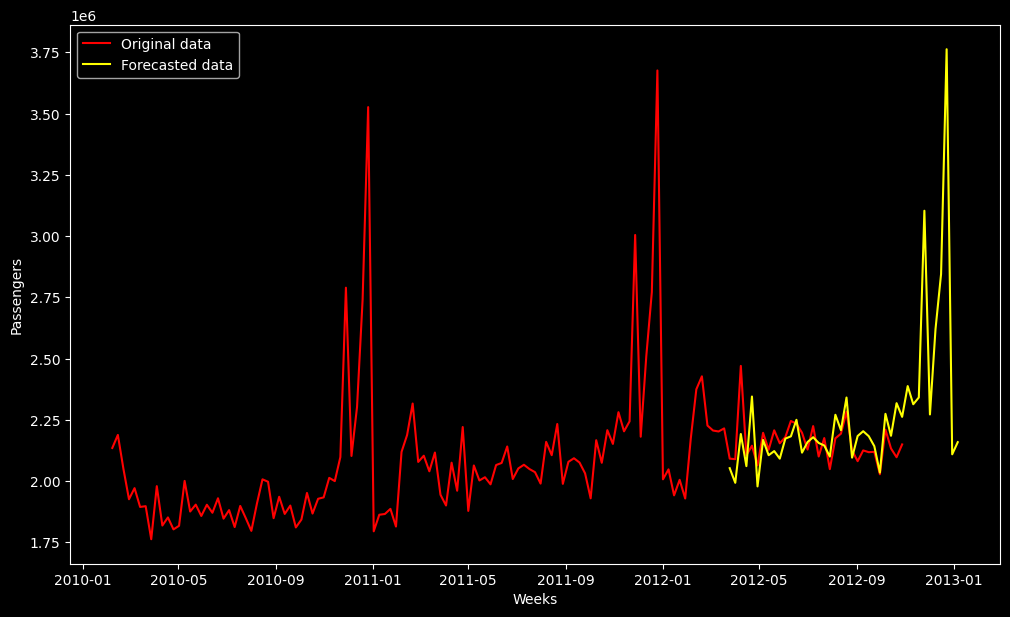

In [50]:
# Forecast the value of next 12 weeks
forecast_4 = sarima_4.forecast(steps=42)

# Visualize the data with forecasted values
plt.figure(figsize=(12, 7))
plt.plot(store_4, color = 'red', label = 'Original data')
plt.plot(forecast_4, color = 'yellow', label = 'Forecasted data')
plt.xlabel('Weeks')
plt.ylabel('Passengers')
plt.legend()
plt.show()

In [51]:
# print the forcasted data
forecast_4.tail(12)

2012-10-21    2.317963e+06
2012-10-28    2.262142e+06
2012-11-04    2.387799e+06
2012-11-11    2.313574e+06
2012-11-18    2.341234e+06
2012-11-25    3.103649e+06
2012-12-02    2.271901e+06
2012-12-09    2.620367e+06
2012-12-16    2.845179e+06
2012-12-23    3.763069e+06
2012-12-30    2.109158e+06
2013-01-06    2.158814e+06
Freq: W-SUN, Name: predicted_mean, dtype: float64

#### 2. Forcasting of store 17

In [52]:
# find the best parameters for store 17
order = auto_arima(store_17, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3718.761, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3771.694, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3730.781, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3717.843, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3769.707, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3719.432, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3719.426, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3720.997, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3716.801, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3718.794, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3718.511, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3728.888, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3719.795, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.107 seconds


In [53]:
# create & train the model
sarima_17 = SARIMAX(train_17,order=(0, 1, 1),seasonal_order=(0, 1, 1, 52))
sarima_17 = sarima_17.fit()

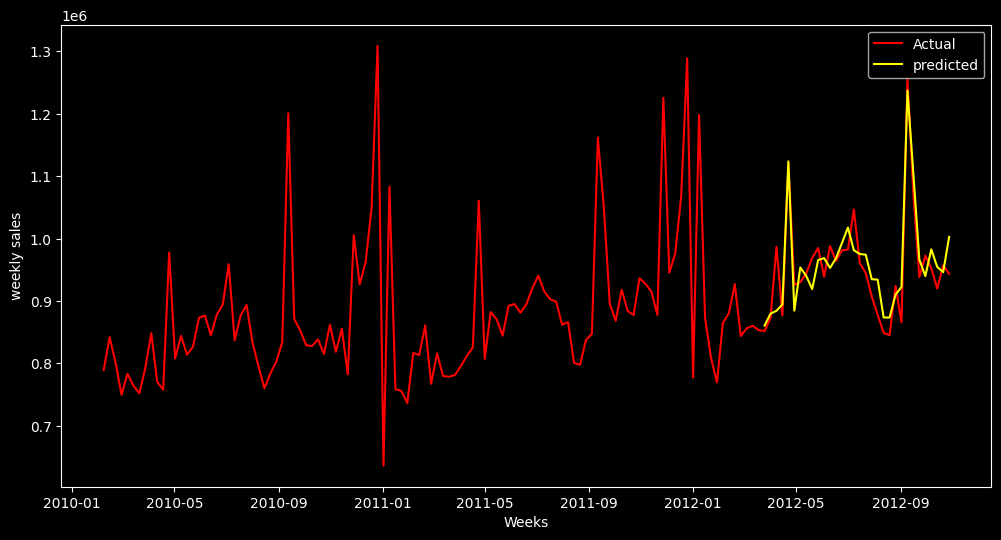

In [54]:
# Predict the data using model
sarima_pred = sarima_17.predict(start = len(train_17), end=len(train_17)+len(test_17)-1, dynamic=True)

# Visualize the predicted data with actual data
plt.figure(figsize=(12, 6))
plt.plot(store_17, color = 'red', label = 'Actual')
plt.plot(sarima_pred, color = 'yellow', label = 'predicted')
plt.xlabel('Weeks')
plt.ylabel('weekly sales')
plt.legend()
plt.show()

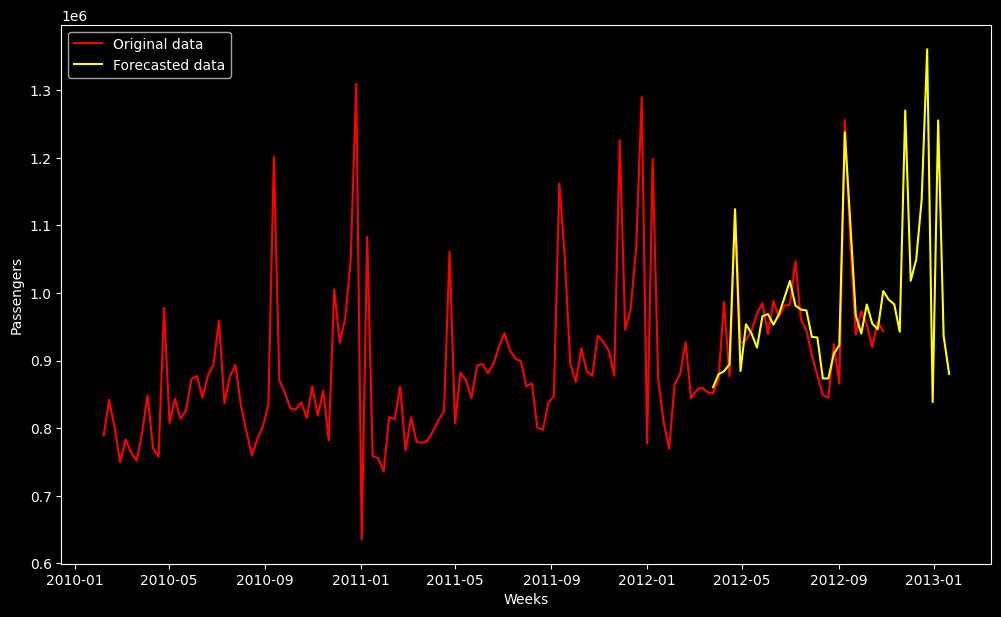

In [55]:
# Forecast the value of next 12 weeks
forecast_17 = sarima_17.forecast(steps=44)

# Visualize the data with forecasted values
plt.figure(figsize=(12, 7))
plt.plot(store_17, color = 'red', label = 'Original data')
plt.plot(forecast_17, color = 'yellow', label = 'Forecasted data')
plt.xlabel('Weeks')
plt.ylabel('Passengers')
plt.legend()
plt.show()

In [56]:
# print the forcasted data
forecast_17.tail(12)

2012-11-04    9.900204e+05
2012-11-11    9.832238e+05
2012-11-18    9.426055e+05
2012-11-25    1.269629e+06
2012-12-02    1.017955e+06
2012-12-09    1.049192e+06
2012-12-16    1.138266e+06
2012-12-23    1.360191e+06
2012-12-30    8.385115e+05
2013-01-06    1.254900e+06
2013-01-13    9.362295e+05
2013-01-20    8.803275e+05
Freq: W-SUN, Name: predicted_mean, dtype: float64

#### 3. Forcasting of store 25

In [57]:
# find the best parameters for store 25
order = auto_arima(store_24, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3841.303, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3849.451, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3837.098, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3840.315, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4448.464, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3838.492, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3838.896, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3840.427, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3899.539, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.588 seconds


In [58]:
# create & train the model
sarima_24 = SARIMAX(train_24, order=(1, 0, 0), seasonal_order=(1, 0, 0, 52))
sarima_24 = sarima_24.fit()

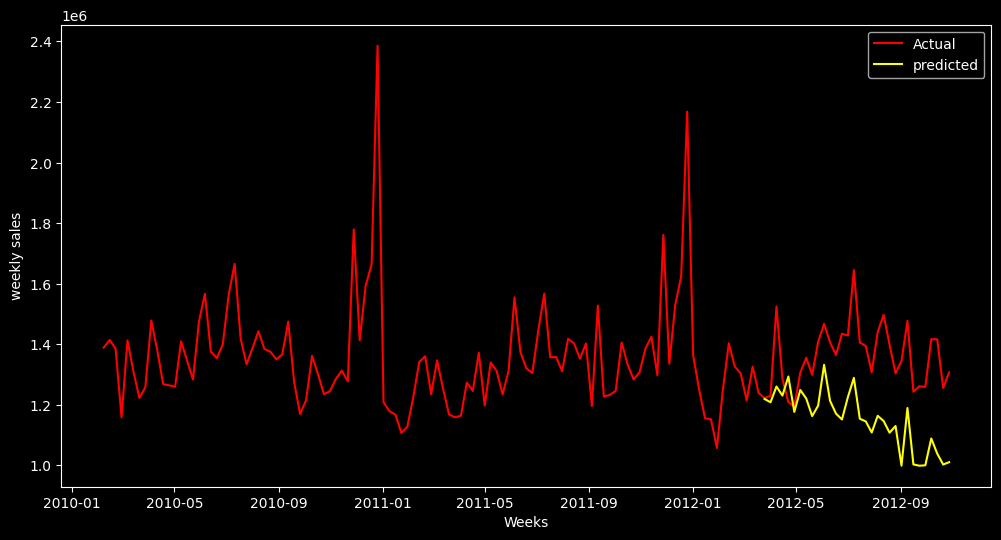

In [59]:
# Predict the data using model
sarima_pred = sarima_24.predict(start = len(train_24), end=len(train_24)+len(test_24)-1, dynamic=True)

# Visualize the predicted data with actual data
plt.figure(figsize=(12, 6))
plt.plot(store_24, color = 'red', label = 'Actual')
plt.plot(sarima_pred, color = 'yellow', label = 'predicted')
plt.xlabel('Weeks')
plt.ylabel('weekly sales')
plt.legend()
plt.show()

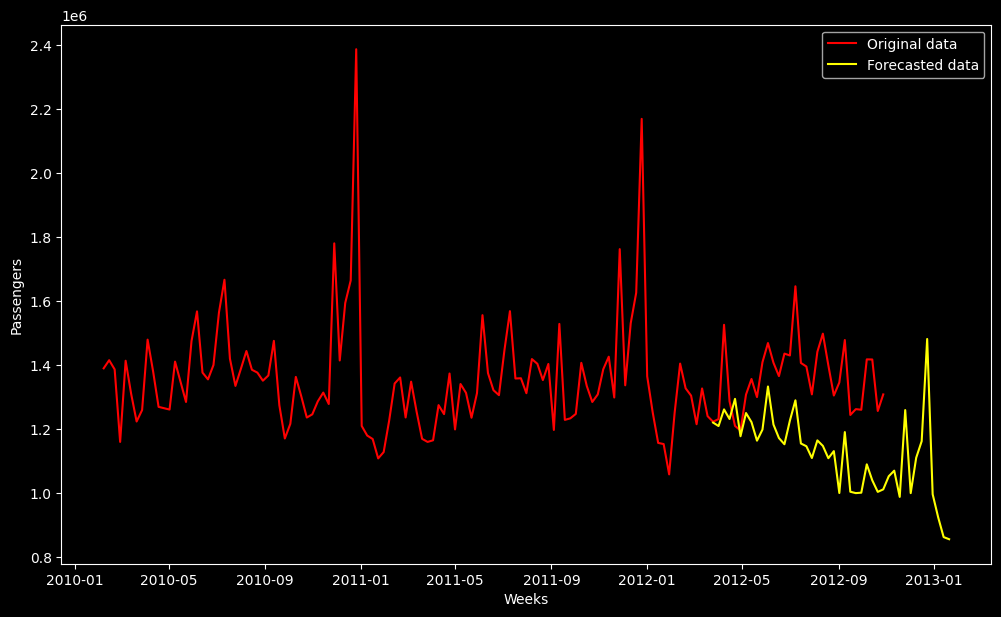

In [60]:
# Forecast the value of next 12 weeks
forecast_24 = sarima_24.forecast(steps=44)

# Visualize the data with forecasted values
plt.figure(figsize=(12, 7))
plt.plot(store_24, color = 'red', label = 'Original data')
plt.plot(forecast_24, color = 'yellow', label = 'Forecasted data')
plt.xlabel('Weeks')
plt.ylabel('Passengers')
plt.legend()
plt.show()

In [61]:
# print the forcasted data
forecast_24.tail(12)

2012-11-04    1.051358e+06
2012-11-11    1.068868e+06
2012-11-18    9.869356e+05
2012-11-25    1.258279e+06
2012-12-02    9.986374e+05
2012-12-09    1.109174e+06
2012-12-16    1.160969e+06
2012-12-23    1.480453e+06
2012-12-30    9.951355e+05
2013-01-06    9.232369e+05
2013-01-13    8.612617e+05
2013-01-20    8.545883e+05
Freq: W-SUN, Name: predicted_mean, dtype: float64

#### 4. Forcasting of store 33

In [62]:
# find the best parameters for store 33
order = auto_arima(store_33, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3280.797, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3282.281, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3290.652, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3278.805, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3350.533, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.001 seconds


In [63]:
# create & train the model
sarima_33 = SARIMAX(train_33, order=(0, 1, 0), seasonal_order=(0, 1, 0, 52))
sarima_33 = sarima_33.fit()

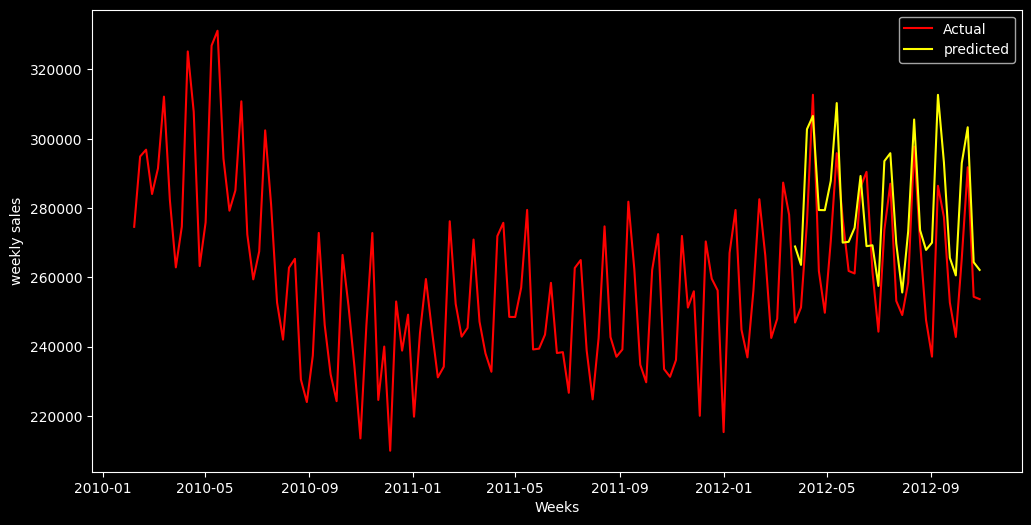

In [64]:
# Predict the data using model
sarima_pred = sarima_33.predict(start = len(train_33), end=len(train_33)+len(test_33)-1, dynamic=True)

# Visualize the predicted data with actual data
plt.figure(figsize=(12, 6))
plt.plot(store_33, color = 'red', label = 'Actual')
plt.plot(sarima_pred, color = 'yellow', label = 'predicted')
plt.xlabel('Weeks')
plt.ylabel('weekly sales')
plt.legend()
plt.show()

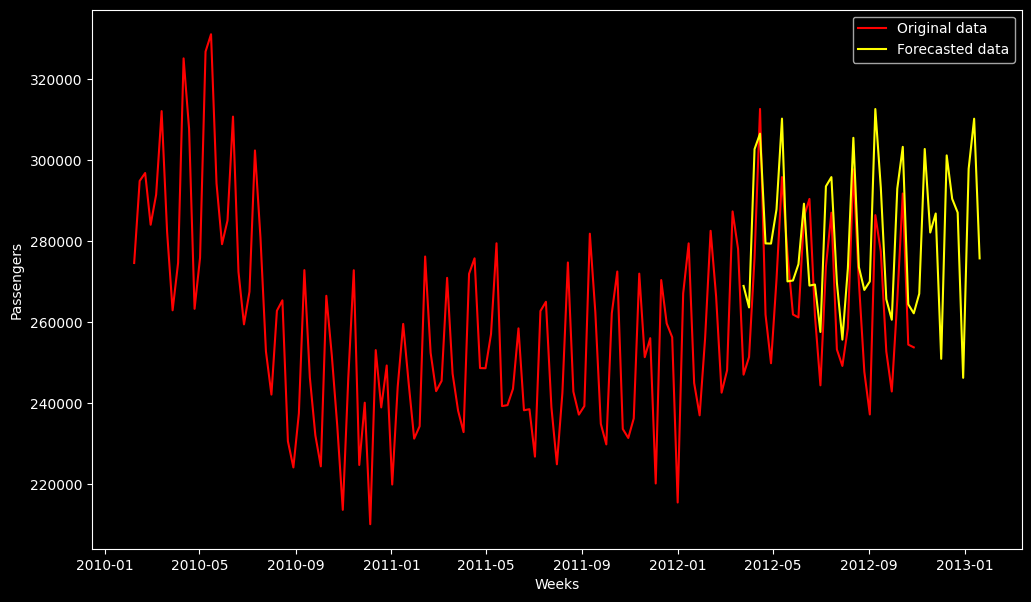

In [65]:
# Forecast the value of next 12 weeks
forecast_33 = sarima_33.forecast(steps=44)

# Visualize the data with forecasted values
plt.figure(figsize=(12, 7))
plt.plot(store_33, color = 'red', label = 'Original data')
plt.plot(forecast_33, color = 'yellow', label = 'Forecasted data')
plt.xlabel('Weeks')
plt.ylabel('Passengers')
plt.legend()
plt.show()

In [66]:
# print the forcasted data
forecast_33.tail(12)

2012-11-04    266990.38
2012-11-11    302794.30
2012-11-18    282127.76
2012-11-25    286829.73
2012-12-02    250893.61
2012-12-09    301206.31
2012-12-16    290471.61
2012-12-23    287068.45
2012-12-30    246192.47
2013-01-06    297891.34
2013-01-13    310280.48
2013-01-20    275732.46
Freq: W-SUN, Name: predicted_mean, dtype: float64

#### 5. Forcasting of store 41

In [67]:
# find the best parameters for store 41
order = auto_arima(store_41, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3834.655, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3875.138, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3850.659, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3840.238, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3873.151, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3841.787, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3841.410, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3828.152, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3831.055, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3832.635, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3827.833, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3823.433, Time=0.32 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3825.120, Time=0.55 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : 

In [68]:
# create & train the model
sarima_41 = SARIMAX(train_41, order=(4, 1, 3), seasonal_order=(4, 1, 3, 52))
sarima_41 = sarima_41.fit()

c:\Users\vinit\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


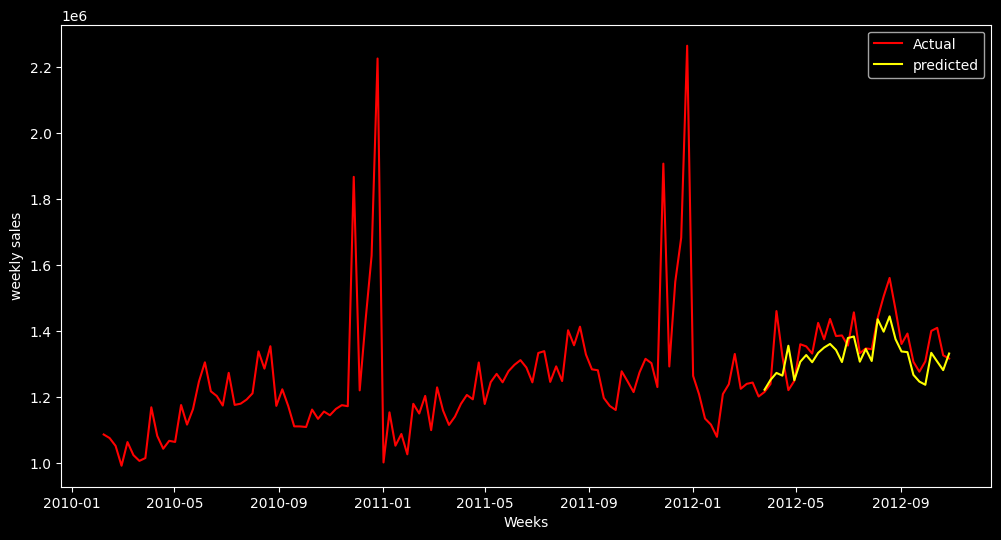

In [69]:
# Predict the data using model
sarima_pred = sarima_41.predict(start = len(train_41), end=len(train_41)+len(test_41)-1, dynamic=True)

# Visualize the predicted data with actual data
plt.figure(figsize=(12, 6))
plt.plot(store_41, color = 'red', label = 'Actual')
plt.plot(sarima_pred, color = 'yellow', label = 'predicted')
plt.xlabel('Weeks')
plt.ylabel('weekly sales')
plt.legend()
plt.show()

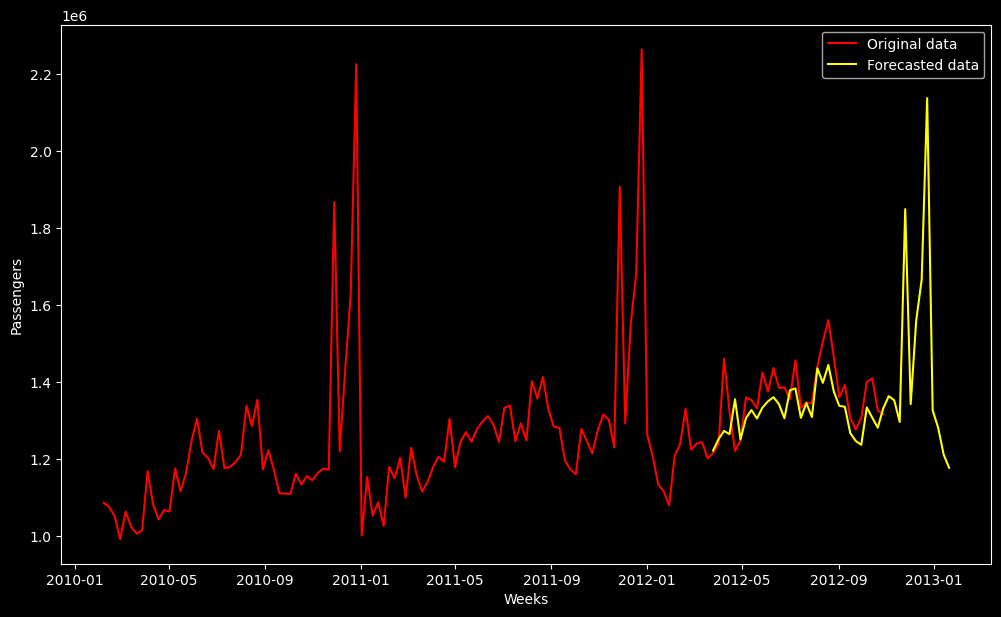

In [70]:
# Forecast the value of next 12 weeks
forecast_41 = sarima_41.forecast(steps=44)

# Visualize the data with forecasted values
plt.figure(figsize=(12, 7))
plt.plot(store_41, color = 'red', label = 'Original data')
plt.plot(forecast_41, color = 'yellow', label = 'Forecasted data')
plt.xlabel('Weeks')
plt.ylabel('Passengers')
plt.legend()
plt.show()

In [71]:
# print the forcasted data
forecast_41.tail(12)

2012-11-04    1.363303e+06
2012-11-11    1.352539e+06
2012-11-18    1.296346e+06
2012-11-25    1.848675e+06
2012-12-02    1.342628e+06
2012-12-09    1.559336e+06
2012-12-16    1.665603e+06
2012-12-23    2.136773e+06
2012-12-30    1.326424e+06
2013-01-06    1.281364e+06
2013-01-13    1.211825e+06
2013-01-20    1.177341e+06
Freq: W-SUN, Name: predicted_mean, dtype: float64

**Insights :-**
- These are the 12 weeks forcasted data of 5 stores

- all models are performing well and predicted data nearly close to actual data

- Except, predicted data of store 24 are little far from actual data, maybe its because of data.

- Except the store 24, everything performed well.

END

---